In [4]:
import uproot
import awkward as ak
import numpy as np

In [39]:
# open file
# https://opendata.cern.ch/record/80017 (ttbar)
file = uproot.open("DAOD_PHYSLITE.37621239._000001.pool.root.1")
# inspect file 
file.keys()

['##Params;3',
 '##Params;2',
 '##Shapes;3',
 '##Shapes;2',
 '##Links;3',
 '##Links;2',
 'MetaData;1',
 'MetaDataHdr;1',
 'MetaDataHdrForm;1',
 'CollectionTree;1',
 'POOLContainer;1',
 'POOLContainerForm;1',
 'POOLCollectionTree;1']

In [40]:
# open ttree
# http://opendata.cern.ch/record/80001
tree = file["CollectionTree"]
# inspect ttree
tree.keys()

['xTrigDecisionAux.',
 'xTrigDecisionAux./xTrigDecisionAux.xAOD::AuxInfoBase',
 'xTrigDecisionAux./xTrigDecisionAux.smk',
 'xTrigDecisionAux./xTrigDecisionAux.bgCode',
 'xTrigDecisionAux./xTrigDecisionAux.tav',
 'xTrigDecisionAux./xTrigDecisionAux.tap',
 'xTrigDecisionAux./xTrigDecisionAux.tbp',
 'xTrigDecisionAux./xTrigDecisionAux.lvl2ErrorBits',
 'xTrigDecisionAux./xTrigDecisionAux.efErrorBits',
 'xTrigDecisionAux./xTrigDecisionAux.lvl2Truncated',
 'xTrigDecisionAux./xTrigDecisionAux.efTruncated',
 'xTrigDecisionAux./xTrigDecisionAux.lvl2PassedPhysics',
 'xTrigDecisionAux./xTrigDecisionAux.efPassedPhysics',
 'xTrigDecisionAux./xTrigDecisionAux.lvl2PassedRaw',
 'xTrigDecisionAux./xTrigDecisionAux.efPassedRaw',
 'xTrigDecisionAux./xTrigDecisionAux.lvl2PassedThrough',
 'xTrigDecisionAux./xTrigDecisionAux.efPassedThrough',
 'xTrigDecisionAux./xTrigDecisionAux.lvl2Prescaled',
 'xTrigDecisionAux./xTrigDecisionAux.efPrescaled',
 'xTrigDecisionAux./xTrigDecisionAux.lvl2Resurrected',
 'xTrigD

In [70]:
Electrons = tree.arrays(["AnalysisElectronsAuxDyn.charge", "AnalysisElectronsAuxDyn.pt","AnalysisElectronsAuxDyn.eta", "AnalysisElectronsAuxDyn.phi","AnalysisElectronsAuxDyn.m"])
Muons = tree.arrays(["AnalysisMuonsAuxDyn.charge", "AnalysisMuonsAuxDyn.pt","AnalysisMuonsAuxDyn.eta", "AnalysisMuonsAuxDyn.phi"])
print("Number of events:", len(Electrons))

Number of events: 30000


In [65]:
# Applying cut for pt>25000
filter_e = (Electrons["AnalysisElectronsAuxDyn.pt"]>25000)
filter_mu = (Muons["AnalysisMuonsAuxDyn.pt"]>25000)
filtered_electrons = Electrons[filter_e]
filtered_muons = Muons[filter_mu]

In [84]:
# Selecting pairs 
mask_e = (ak.num(filtered_electrons["AnalysisElectronsAuxDyn.pt"]) >= 2)
electron_pairs = ak.mask(filtered_electrons,mask_e)
mask_mu = (ak.num(filtered_muons["AnalysisMuonsAuxDyn.pt"]) >= 2)
muon_pairs = ak.mask(filtered_muons,mask_mu)

In [44]:
# Fn. To Calculate Invm
def Px(pt, phi):
    return pt*np.cos(phi)

def Py(pt,phi):
    return pt*np.sin(phi)

def Pz(pt,eta):
    return pt*np.sinh(eta)

def E(pt, eta, m):
    return np.sqrt(pt**2 * np.cosh(eta)**2 + m**2)

def calc_invm(pt1,eta1,phi1,m1, pt2,eta2,phi2,m2):
    sumpx = Px(pt1,phi1) + Px(pt2,phi2)
    sumpy = Py(pt1,phi1) + Py(pt2,phi2)
    sumpz = Pz(pt1,eta1) + Pz(pt2,eta2)
    sumE = E(pt1,eta1,m1) + E(pt2,eta2,m2)
    invm = np.sqrt(sumE**2 - sumpx**2 - sumpy**2 - sumpz**2)
    return invm/1000.0


In [45]:
# Select only oppositely charged pairs
electron_invm = []
for i in range(len(electron_pairs)):
    if isinstance(electron_pairs["AnalysisElectronsAuxDyn.charge"][i], ak.highlevel.Array):
        size = len(electron_pairs["AnalysisElectronsAuxDyn.charge"][i])
        invm_event = []
        for j in range(size):
            for k in range(j+1, size):
                if electron_pairs["AnalysisElectronsAuxDyn.charge"][i][j] != electron_pairs["AnalysisElectronsAuxDyn.charge"][i][k]:
                    invm = calc_invm(electron_pairs["AnalysisElectronsAuxDyn.pt"][i][j], electron_pairs["AnalysisElectronsAuxDyn.eta"][i][j], electron_pairs["AnalysisElectronsAuxDyn.phi"][i][j], electron_pairs["AnalysisElectronsAuxDyn.m"][i][j], electron_pairs["AnalysisElectronsAuxDyn.pt"][i][k],electron_pairs["AnalysisElectronsAuxDyn.eta"][i][k], electron_pairs["AnalysisElectronsAuxDyn.phi"][i][k], electron_pairs["AnalysisElectronsAuxDyn.m"][i][k])
                    invm_event += [invm]
        electron_invm += [invm_event]
    else:
        electron_invm += [[np.nan]]

muon_invm = []
for i in range(len(muon_pairs)):
    if isinstance(muon_pairs["AnalysisMuonsAuxDyn.charge"][i], ak.highlevel.Array):
        size = len(muon_pairs["AnalysisMuonsAuxDyn.charge"][i])
        invm_event = []
        for j in range(size):
            for k in range(j+1, size):
                if muon_pairs["AnalysisMuonsAuxDyn.charge"][i][j] != muon_pairs["AnalysisMuonsAuxDyn.charge"][i][k]:
                    invm = calc_invm(muon_pairs["AnalysisMuonsAuxDyn.pt"][i][j], muon_pairs["AnalysisMuonsAuxDyn.eta"][i][j],muon_pairs["AnalysisMuonsAuxDyn.phi"][i][j], 0, muon_pairs["AnalysisMuonsAuxDyn.pt"][i][k], muon_pairs["AnalysisMuonsAuxDyn.eta"][i][k],muon_pairs["AnalysisMuonsAuxDyn.phi"][i][k], 0)
                    invm_event += [invm]
        muon_invm += [invm_event]
    else:
        muon_invm += [[np.nan]]


In [73]:
ak_muons = ak.Array(muon_invm)
ak_electrons = ak.Array(electron_invm)
print("Number of events:",len(ak_electrons))

Number of events: 30000


In [27]:
# we can create new file with output
#print("electron_invm", electron_invm)
#new_file = uproot.recreate("output_tree_invm.root", compression=uproot.ZSTD(5))
#new_file["MyTree"] = {"ElectronPairsInvariantMass": ak_electrons, "MuonPairsInvariantMass": ak_muons}

Number of lepton pairs 2451


Text(0.5, 0, '[GeV]')

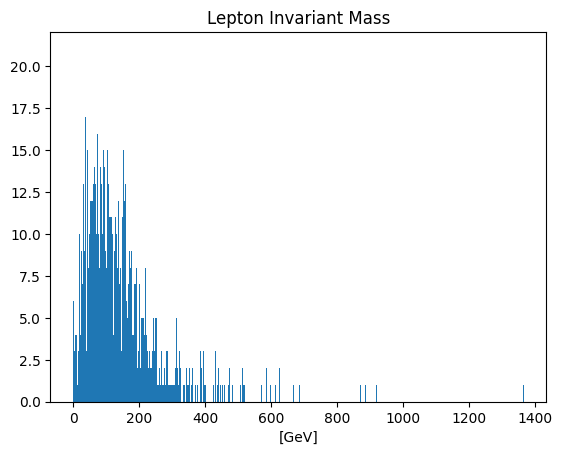

In [55]:
# or print histogram
import matplotlib.pyplot as plt
flat_electrons = ak.flatten(ak_electrons)
flat_muons = ak.flatten(ak_muons)
leptons = np.concatenate((flat_electrons, flat_muons))
# take away nan values 
leptons = leptons[~np.isnan(leptons)]
print("Number of lepton pairs",len(leptons))
plt.hist(leptons, bins=np.arange(min(leptons),max(leptons) +2) - 0.5)
plt.title("Lepton Invariant Mass")
plt.xlabel("[GeV]")

In [63]:
hist, bins = np.histogram(leptons, bins=np.arange(min(leptons),max(leptons) +2) - 0.5)
peak_index = np.argmax(hist)
peak_value = hist[peak_index]
peak_x = (bins[peak_index] + bins[peak_index + 1]) /2
peak_x

94.17671866169059

In [85]:
# # 
# def selection(events):
#     leptons = ak.zip(
#     {
#         "pt":  events.lep_pt,
#         "eta": events.lep_eta,
#         "phi": events.lep_phi,
#         "energy": events.lep_E,
#         "charge": events.lep_charge,
#         "isTight": events.lep_isTightID,
#         "pdgId": events.lep_type
#     },
#     with_name="PtEtaPhiECandidate",
#     behavior = candidate.behavior,
#     )

#     lep1_isMu = (leptons[:,0].pdgId == 13)
#     lep2_isMu = (leptons[:,1].pdgId == 13)
#     isMus = lep1_isMu & lep2_isMu
    
#     opp_charge = (ak.prod(leptons.charge, axis = 1) == -1)
#     bothTight = ak.all(leptons.isTight, axis = 1)
#     cut = opp_charge & isMus & bothTight
    
#     return events[cut]